In [2]:
%matplotlib inline
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", color_codes=True)

import loc_utils as lut
from standards import *

s = SURix()
r = RAWix()
r.cols.insert(0,'group')

## Open Loop

The goal of the open loop analysis is to **characterize which factors impact game choice on the first trial and how this varies by training group**. We will be using the **SUR (seemingly unrelated regressions)** technique. Detailed recipe follows.

The idea is to get separate regression coefficients indicating the effect of 3 predictors for each task and each group. That is, we will end up with $3\times4\times4 = 48$ coefficient values ($\beta$-values) and their confidence intervals (or significance).

We will fit $Y = \beta X$, where $Y$ is a vector with ~1600 entries and $X$ is a matrix with ~1600 rows and 48 columns.

Here’s how to build up $Y$ and $X$. (For the sake of the discussion we will assume that we have 100 people for each of the 4 groups).

Your $Y$ matrix (the predicted variable) is a vector with $4\times4\times100 = 1600$ entries, each of which is 0 or 1. They are ordered by task and group:
* 1:100: 1D task, group 1
* 101-200: I1D task, group 1
* 201-300: 2D task, group 1
* 301-400: R task, group 1
* … and so on for the other 3 groups

Each entry in $Y$ represents one person and one task. It is 1 if that person chose that task and 0 otherwise.

Your $X$ (design) matrix has 1600 rows (corrresponding to the length of Y) and $3\times3\times4 = 36$ columns. The columns come in batches of 3, in the same order of the task and group that you used for $Y$. For each task and group, you have 3 predictors: $\beta_1$ captures the effect of $PC$, $\beta_2$ captures the effect of $LRN$ and $\beta_3$ captures the effect of $PC_{change}$ or $LP$. (Define further below). The columns are ordered like so:
* col 1-3: $\beta_1$, $\beta_2$, $\beta_3$, for task 1D, group 1
* col 4-6: $\beta_1$, $\beta_2$, $\beta_3$, for task I1D, group 1
* col 7-9: $\beta_1$, $\beta_2$, $\beta_3$, for task 2D, group 1
* col 10-12: $\beta_1$, $\beta_2$, $\beta_3$, for task R, group 1
* … and so on for the other 4 groups

Each column has the appropriate entries in the corresponding places and is 0 otherwise.
That is: columns 1-3 have entries in rows 1-100 (corresponding to 1D, group 1) and are 0 everywhere else
columns 4-6 have entries in rows 101-200, and are 0 everywhere else,
… and so on

This will give us the coefficients we want. For instance, col 1 will show the weight of PC on the choices of task 1D for group 1; col2 will show the weight of LRN for the same task and group; col 4 will show the weight of PC for task I1D and group 1 … and so on

Now, let’s define the predictors that give rise to the betas:
* $\beta_1$: captures the effect of the percent correct (or total nb of correct) over the 15 training trials.
* $\beta_2$:captures the effect of the LRN rating;
* $\beta_3$: captures the effect of increase in PC over the 15 training trials. 
To get this, run a separate regression where $Y$ is the string of 0s and 1ns during training, and $x$ is the trial number: $Y = \beta_0+\beta_1\times x$. $\beta_1$ is the measure of the slope; if it is positive it means the person improved during training; if negative, he got worse; if 0, he did not change. Then you enter the this $\beta_1$ as a predictor in the 3rd column of the larger regression.

Notes:
For both $PC$ and the $LRN$ regressors I would use the ranked rating to avoid confounds with overall rating magnitudes. That is, order all the PC values that a person gave (across the 4 tasks) in increasing order, and recode them as 1,2,3,4. Break ties randomly. Do the same for the LRN ratings.

All regressors should be standardized so that we can compare the coefficient magnitudes.
The easiest way to standardize is to take each group of 100 people in the matrix and z-score all the values using the mean and stdev of that value for that group.

## Histograms by group (free / strategic) and condition (inf. / uninf.)

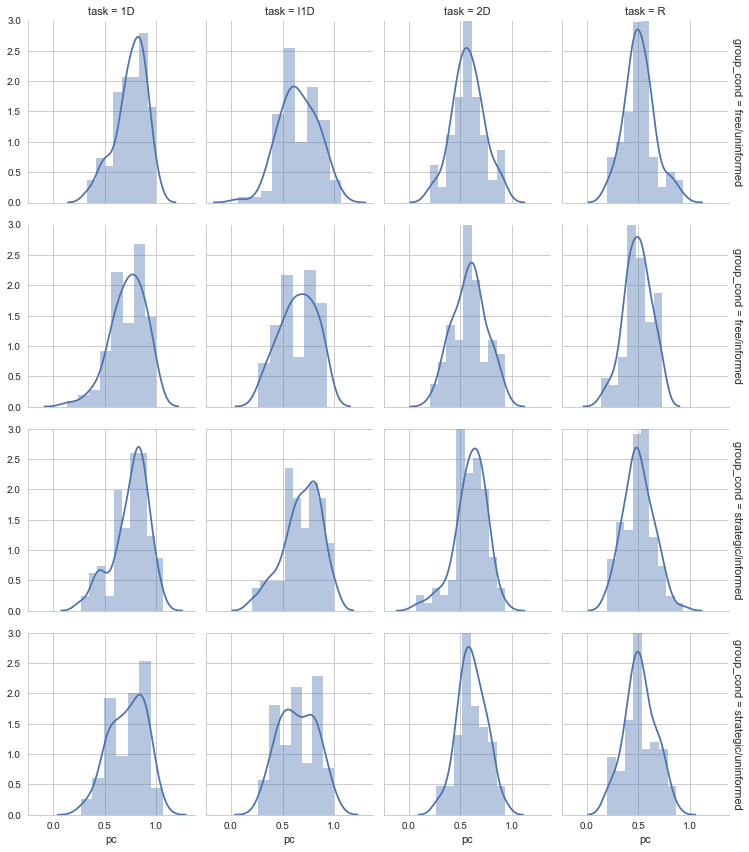

In [9]:
data = lut.unpickle('open_loop_data/SUR_data_2.pkl')

df = pd.DataFrame(data, columns=s.cols)
df.sid = df.sid.astype(int)
df.pc_rank = df.pc_rank.astype(int)
df.lrn_rank3 = df.lrn_rank3.astype(int)
df.lrn_rank4 = df.lrn_rank4.astype(int)
df.group = df.group.replace([0,1], ['free', 'strategic'])
df.cond = df.cond.replace([0,1], ['uninformed', 'informed'])
df.task = df.task.replace([1,2,3,4], ['1D', 'I1D', '2D', 'R'])
df.choice = df.choice.replace([1,2,3,4], ['1D', 'I1D', '2D', 'R'])
df['group_cond'] = df.group + '/' + df.cond

g = sns.FacetGrid(df, col='task', row='group_cond', margin_titles=True)
g.map(sns.distplot, 'pc')
plt.subplots_adjust(right=.85)
del data
# plt.savefig('figures/pc_by_group_and_task.pdf')

## Performance by group and task

In [ ]:
data1 = lut.unpickle('open_loop_data/SUR_data_1.pkl')
data2 = lut.unpickle('pickled_data/combined.pkl')
train_trials = data2[:,r.ix('stage')]==0
data2 = data2[train_trials, :]

x1 = np.arange(0,15).reshape([-1, 1])
x0 = np.ones_like(x1)

df = pd.DataFrame(data2, columns=r.cols)
df.sid = df.sid.astype(int)
# df.sort_values(by=['group', 'cond', 'cat'], axis=0)
df.group = df.group.replace([0,1], ['free', 'strategic'])
df.cond = df.cond.replace([0,1], ['uninformed', 'informed'])
df.cat = df.cat.replace([1,2,3,4], ['1D', 'I1D', '2D', 'R'])
df['group_cond'] = df.group.astype(str) + '/' + df.cond.astype(str)

sns.lmplot(x='blkt', y='cor', data=df, y_jitter=.05, row='group_cond', col='cat', scatter_kws={'alpha':0.1},
          col_order=reversed(['1D', 'I1D', '2D', 'R']))

plt.subplots_adjust(right=.85)
# plt.savefig('figures/hits_by_group_and_task.pdf')

del data1
del data2

In [ ]:
# data = lut.unpickle('open_loop_data/SUR_data_2.pkl')

# df = pd.DataFrame(data, columns=s.cols)
# df.sid = df.sid.astype(int)
# df.pc_rank = df.pc_rank.astype(int)
# df.lrn_rank = df.lrn_rank.astype(int)
# df.group = df.group.replace([0,1], ['free', 'strategic'])
# df.cond = df.cond.replace([0,1], ['uninformed', 'informed'])
# df.task = df.task.replace([1,2,3,4], ['1D', 'I1D', '2D', 'R'])
# df.choice = df.choice.replace([1,2,3,4], ['1D', 'I1D', '2D', 'R'])
# df['group_cond'] = df.group + '/' + df.cond

# toplot = df[df.task==df.choice]
# toplot

# f = plt.figure(3)

# g = sns.FacetGrid(df, row='cond', col='group', margin_titles=True)
# # g.map(sns.violinplot, x='task', y='lp1', data=toplot)
# g.map(sns.stripplot, x='pc_rank', y='lrn', data=toplot, jitter=.2)
# # sns.barplot(x='task', y='lp3', data=toplot, hue='group')
# # plt.savefig('figures/lrn_vs_pc_by_group_and_task.pdf')

# # sns.lmplot(x='lrn', y='task', data=toplot, y_jitter=.05, row='cat', col='group_cond', scatter_kws={'alpha':0.1})

# del data

## Confusing scatterplots

DONE


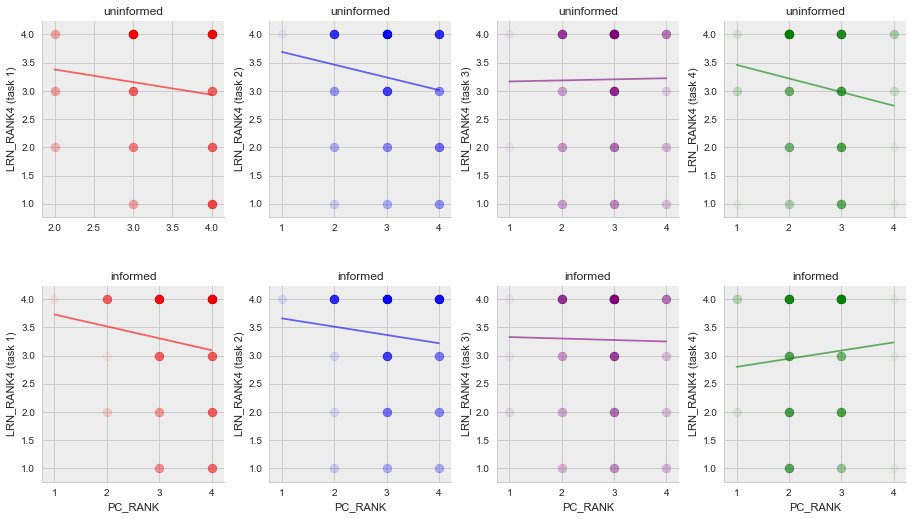

In [6]:
data = lut.unpickle('open_loop_data/SUR_data_2.pkl')

fig = plt.figure(2, figsize=(16,8))

cm = ['red','blue','purple','green']

spix=0
xd = 'pc_rank'
yd = 'lrn_rank4'
# for grp in [0,1]:
for cnd in [0,1]:
    for i, tsk in enumerate([1,2,3,4]):
        spix += 1
        ax = fig.add_subplot(2,4,spix, facecolor='#EDEDED')
        ax.set_title('informed' if cnd else 'uninformed')
        ax.set_ylabel('{} (task {})'.format(yd.upper(), tsk))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if spix >= 5: ax.set_xlabel(xd.upper())
        mask = lut.get_mask(data, {s.ix('cond'):cnd, s.ix('task'):tsk})
        X = data[mask, s.ix(xd)] #; ax.set_xlim(-.5,3)
        Y = data[mask, s.ix(yd)] #; ax.set_ylim(0.5,4.5)
        ax.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)), c=cm[i], alpha=.6)
        for x, y in zip(X, Y):
            ax.scatter(x, y, alpha=.05, c=cm[i], s=80)

fig.subplots_adjust(left=.1, bottom=.1, right=.85, top=.9, wspace=.25, hspace=.35)
print('DONE')
# fig.savefig('figures/mean_pc_correct_by_groups.png')

In [8]:
from scipy.stats import rankdata
rankdata([0, 0, 0, 1, 1, 1, 3, 3, 3, 4, 4, 4], method='dense')

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])